## XGBoost training development notebook 

Using run: `g`

**Run tag:** `g`

- Apply full selection cuts with start/end time cuts at [420, 1700] ns 
- We use full combinatorics and NaN for empty coincidences                                                                                       
- Group by event/subrun metadata for efficiency metrics 

**Training strategy**

- Features: 
['dT', 'crv_z', 'crv_y', 'crv_x', 'angle', 'nLayers', 'PEs', 'nHits', "sector"]
- Try to address class imbalance?



In [3]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Internal modules 
sys.path.extend(["../../src/core", "../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [7]:
run = "g"
base_in_path = Path(f"../../output/ml/{run}/data/")
cry_in_path = base_in_path / "CRY_onspill-LH_aw"
ce_mix_in_path = base_in_path/ "CE_mix2BB_onspill-LH_aw"

cry_data = Load(in_path=cry_in_path).load_pkl()
ce_mix_data = Load(in_path=ce_mix_in_path).load_pkl()

[Load] ✅ Initialised with out_path=../../output/ml/g/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/ml/g/data/CRY_onspill-LH_aw/results.pkl
[Load] ✅ Initialised with out_path=../../output/ml/g/data/CE_mix2BB_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/ml/g/data/CE_mix2BB_onspill-LH_aw/results.pkl


In [8]:
display(cry_data["cut_flow"])
display(ce_mix_data["cut_flow"])

,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,2610933,100.000,100.000,No selection applied
1,has_trk_front,Preselect,2558235,97.982,97.982,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,2558229,97.981,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,2478081,94.912,96.867,Electron track fits
4,one_reco_electron,Preselect,2050975,78.553,82.765,One reco electron / event
5,is_downstream,Preselect,1127230,43.173,54.961,Has downstream track (p_z > 0 in tracker)
6,is_truth_electron,Preselect,320790,12.286,28.458,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,253943,9.726,79.162,Track fit quality > 0.2
8,within_t0,Tracker,203324,7.787,80.067,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,188703,7.227,92.809,Track fit t0 uncertainty (t0err < 0.9 ns)


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,1339362,100.000,100.000,No selection applied
1,has_trk_front,Preselect,1336979,99.822,99.822,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,1336978,99.822,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,1327517,99.116,99.292,Electron track fits
4,one_reco_electron,Preselect,1097128,81.914,82.645,One reco electron / event
5,is_downstream,Preselect,1096128,81.840,99.909,Has downstream track (p_z > 0 in tracker)
6,is_truth_electron,Preselect,1096059,81.834,99.994,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,883133,65.937,80.573,Track fit quality > 0.2
8,within_t0,Tracker,655446,48.937,74.218,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,636329,47.510,97.083,Track fit t0 uncertainty (t0err < 0.9 ns)


[Load] ✅ Initialised with out_path=test_out
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[Plot] ⭐️ Initialised
[Plot] ✅ 	Wrote ../../output/images/ml/g/preparation/h1o_3x3_cuts_CRY.png
[Plot] ✅ 	Wrote ../../output/images/ml/g/preparation/h1o_3x3_cuts_CRY.png


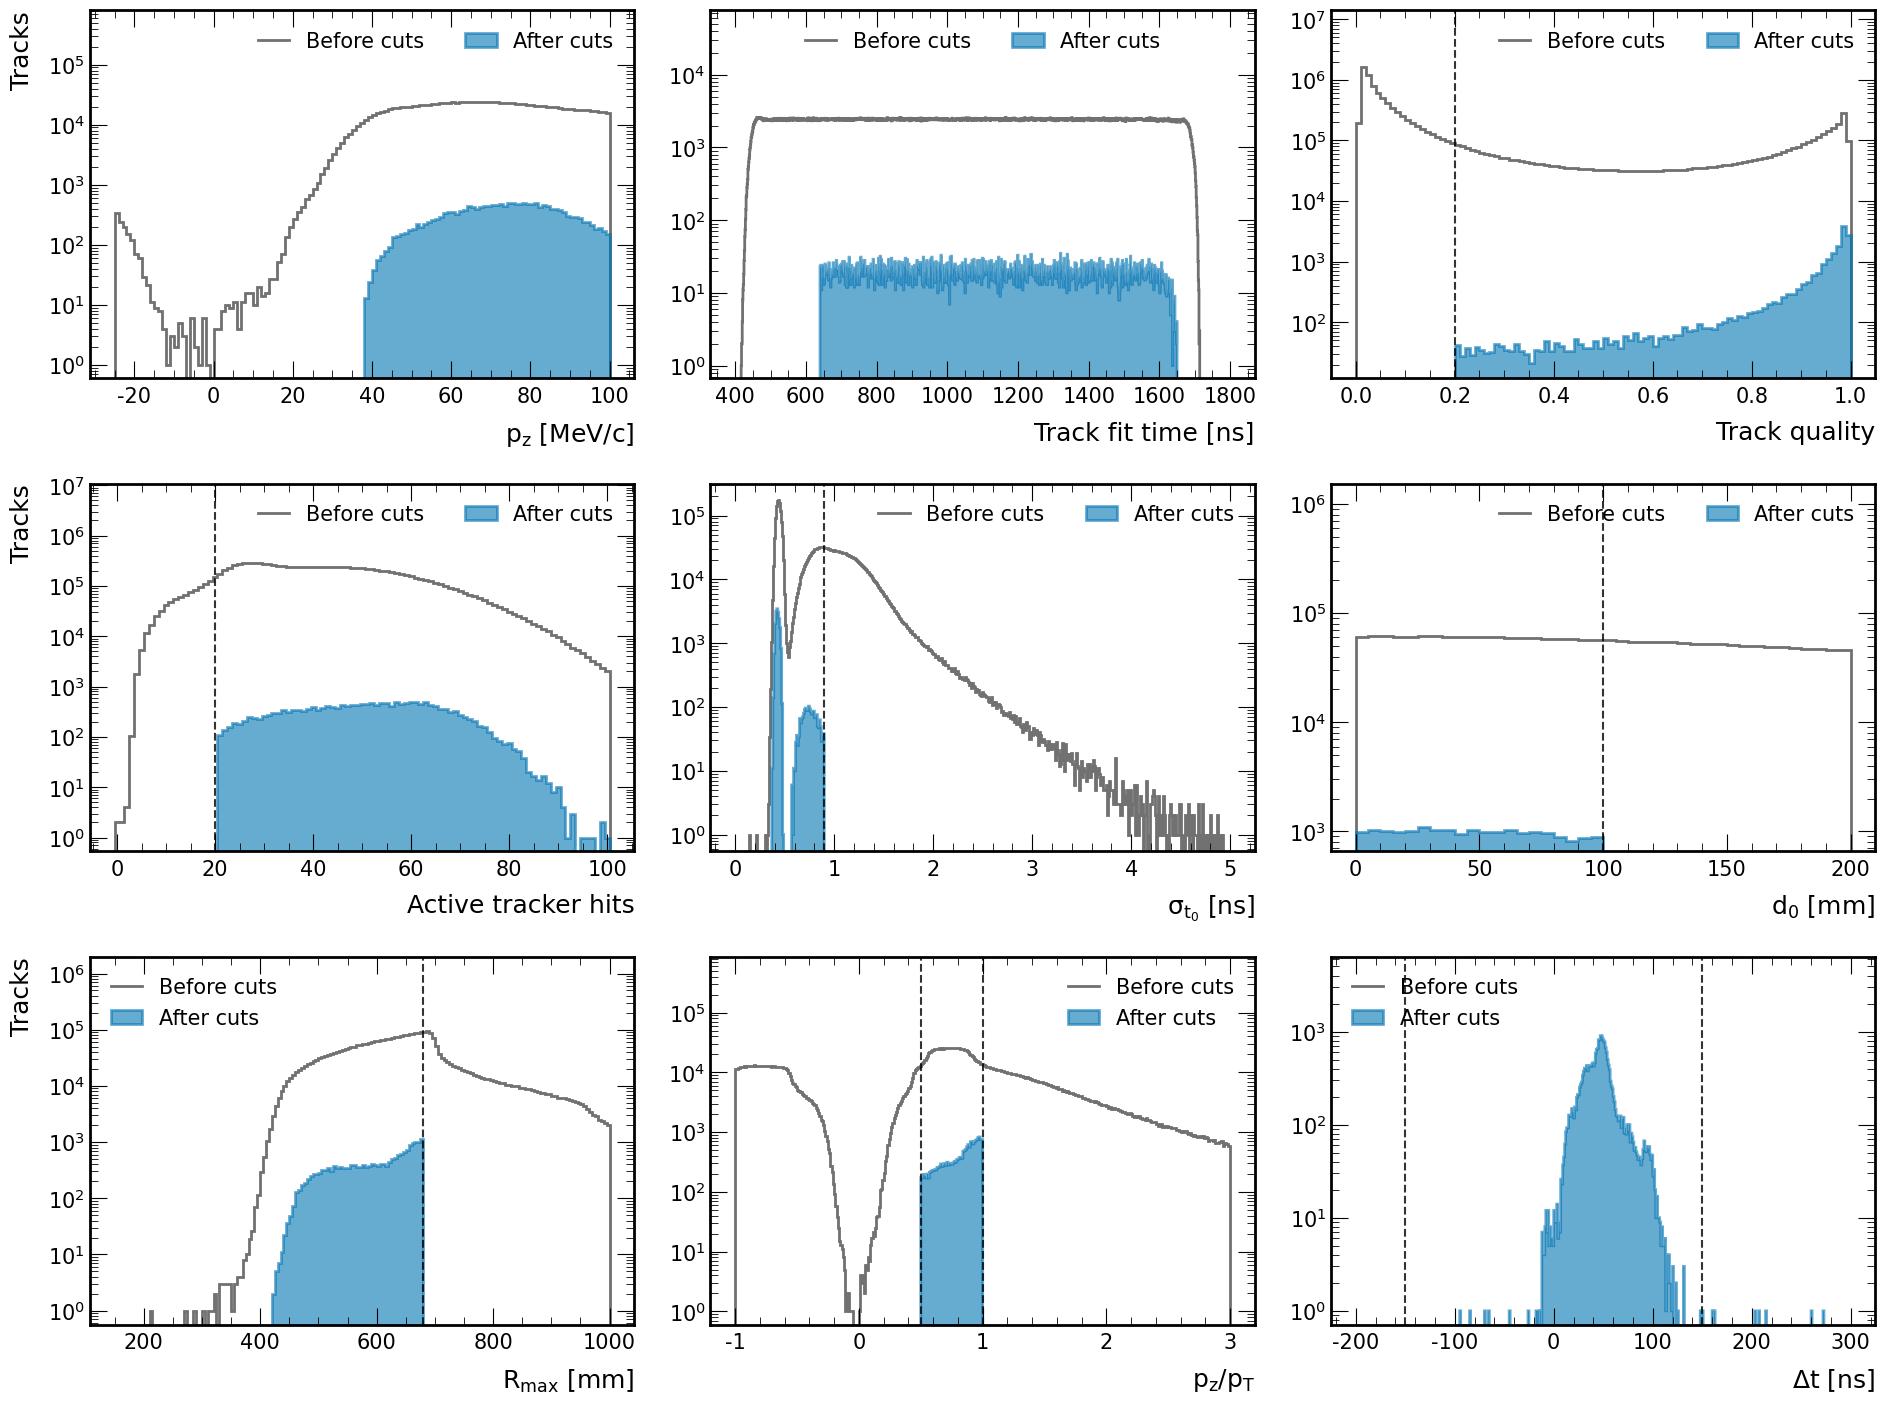

In [9]:
draw = Draw()

img_base_path = Path(f"../../output/images/ml/{run}")
img_prep_out_path = img_base_path / "preparation"
img_prep_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_prep_out_path / "h1o_2x2_features.png"

draw.plot_summary(cry_data["hists"], out_path = img_prep_out_path / "h1o_3x3_cuts_CRY.png")


## Pandas

Index(['event', 'subrun', 'crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits',
       'nLayers', 'angle', 'timeStart', 'timeEnd', 'sector', 'PEs_per_hit',
       't0', 'd0', 'tanDip', 'maxr', 'mom_mag', 'label'],
      dtype='object')
Index(['event', 'subrun', 'crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits',
       'nLayers', 'angle', 'PEs_per_hit', 't0', 'd0', 'tanDip', 'maxr',
       'mom_mag', 'label'],
      dtype='object')


In [10]:
# Convert to DataFrame
df_cry = ak.to_dataframe(cry_data["events"])
df_ce_mix = ak.to_dataframe(ce_mix_data["events"])

# SORT by event IDs to ensure reproducibility
df_cry = df_cry.sort_values(['subrun', 'event']).reset_index(drop=True)
df_ce_mix = df_ce_mix.sort_values(['subrun', 'event']).reset_index(drop=True)
# Add labels
df_cry["label"] = 1 # "signal"
df_ce_mix["label"] = 0 # "background"


## Sanity checks

In [18]:
print(df_cry.columns)
print(df_ce_mix.columns)

Index(['event', 'subrun', 'crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits',
       'nLayers', 'angle', 'timeStart', 'timeEnd', 'sector', 'PEs_per_hit',
       't0', 'd0', 'tanDip', 'maxr', 'mom_mag', 'label'],
      dtype='object')
Index(['event', 'subrun', 'crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits',
       'nLayers', 'angle', 'timeStart', 'timeEnd', 'sector', 'PEs_per_hit',
       't0', 'd0', 'tanDip', 'maxr', 'mom_mag', 'label'],
      dtype='object')


In [19]:
display(df_cry)

,event,subrun,crv_x,crv_y,crv_z,PEs,dT,nHits,nLayers,angle,timeStart,timeEnd,sector,PEs_per_hit,t0,d0,tanDip,maxr,mom_mag,label
0,297834.0,0.0,1186.820190,2706.690918,-4219.373535,958.692322,33.684631,20.0,4.0,-0.401906,1374.617065,1462.117065,3.0,47.934616,1392.382629,30.735674,0.661175,665.820374,118.509651,1
1,54192.0,2.0,-1284.095581,2705.468018,-6695.800781,661.334229,50.609017,19.0,4.0,-0.625724,1377.609009,1477.609009,3.0,34.807065,1415.306893,42.473888,0.856898,655.046692,125.300545,1
2,202661.0,8.0,-618.706482,2708.512695,-6124.572754,662.664734,49.991877,17.0,4.0,0.328578,910.200256,1047.700195,3.0,38.980278,938.468928,56.583725,0.895159,522.516418,120.489052,1
3,64961.0,18.0,1898.635254,2717.003906,-3529.952881,2065.129150,19.332711,20.0,4.0,-1.219407,817.853699,917.853699,3.0,103.256458,826.193490,1.712143,0.664076,640.109741,119.235008,1
4,154520.0,19.0,1663.867798,2701.195557,-6665.435547,751.393799,54.263962,17.0,4.0,-0.336909,1116.517090,1216.517090,3.0,44.199635,1156.544479,99.678917,0.929864,512.688660,87.586723,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23070,475012.0,82311.0,-806.734680,2706.324951,-6085.005371,642.074219,56.555711,17.0,4.0,-0.202566,660.687500,773.187500,3.0,37.769072,696.238511,22.991995,0.856857,523.682373,102.549767,1
23071,14026.0,82313.0,-2582.477295,-510.507782,-4997.416992,693.392029,29.603728,16.0,4.0,0.138613,1445.488159,1520.488159,1.0,43.337002,1452.399382,27.148035,0.828763,654.075439,137.838303,1
23072,14026.0,82313.0,2581.524902,2350.318848,-5400.102539,730.296509,51.350188,16.0,4.0,0.328586,1407.988159,1507.988159,2.0,45.643532,1452.399382,27.148035,0.828763,654.075439,137.838303,1
23073,94868.0,82313.0,-2587.357666,1180.795410,-4291.889160,700.614563,38.191801,16.0,4.0,0.333110,1243.697998,1318.697998,1.0,43.788410,1257.850980,48.847801,0.746904,652.518372,117.341492,1


In [20]:
display(df_ce_mix)

,event,subrun,crv_x,crv_y,crv_z,PEs,dT,nHits,nLayers,angle,timeStart,timeEnd,sector,PEs_per_hit,t0,d0,tanDip,maxr,mom_mag,label
0,33.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,984.055734,72.927025,0.790187,599.885925,104.405853,0
1,41.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.144403,2.771540,0.695981,542.568909,103.011726,0
2,47.0,0.0,4158.908691,2890.122559,-9957.799805,232.260513,-453.753769,13.0,4.0,0.193148,1104.409546,1366.909546,4.0,17.866193,730.014786,15.792412,0.708829,563.176941,104.481087,0
3,47.0,0.0,4241.180176,2902.575928,-9957.799805,298.625183,-156.201584,9.0,4.0,0.737605,866.909546,991.909546,4.0,33.180576,730.014786,15.792412,0.708829,563.176941,104.481087,0
4,63.0,0.0,2600.070312,275.529999,-1832.632690,167.828186,-569.190564,6.0,3.0,0.886308,1259.100586,1321.600586,2.0,27.971364,667.779651,29.744358,0.642257,533.654602,104.225929,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421264,3942.0,999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279.827388,40.706699,0.654384,604.546143,104.696396,0
421265,3951.0,999.0,2587.884521,275.529999,-3380.805420,180.816010,129.109887,5.0,3.0,0.330113,694.516602,757.016602,2.0,36.163202,795.860619,30.999966,0.857855,472.931915,103.161331,0
421266,3952.0,999.0,-2569.493652,275.529999,-4665.379883,73.967308,3.223585,5.0,3.0,-8.101271,1136.499512,1236.499512,1.0,14.793462,1137.766553,38.688007,0.773310,571.792358,104.312691,0
421267,3952.0,999.0,4322.526855,2891.351318,-9957.799805,243.917892,678.764173,15.0,4.0,0.842219,448.999542,761.499512,4.0,16.261193,1137.766553,38.688007,0.773310,571.792358,104.312691,0


In [21]:
display(df_cry[df_cry.isna().any(axis=1)])

,event,subrun,crv_x,crv_y,crv_z,PEs,dT,nHits,nLayers,angle,timeStart,timeEnd,sector,PEs_per_hit,t0,d0,tanDip,maxr,mom_mag,label
1394,283585.0,4846.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1453.642307,72.419334,0.939722,485.961884,118.953232,1
5647,359830.0,19742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,832.782494,83.072769,0.648481,644.992310,135.122314,1
6490,143277.0,22708.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1165.338273,75.040222,0.892652,618.420593,112.870438,1
7395,93561.0,25833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1507.505796,9.171046,0.806056,511.993317,103.895325,1
14912,26573.0,52972.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1452.781623,87.510765,0.997677,575.051086,106.445419,1
22138,161916.0,78889.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1636.684580,78.307076,0.905462,580.694458,105.390053,1


In [22]:
# Check if multiplicity is working 

# Find how many rows per run/subrun
df_cry.groupby(['subrun', 'event']).size().reset_index(name='count')

# Or show only those with multiple rows
grouped = df_cry.groupby(['subrun', 'event']).size()
grouped[grouped > 1]

df_cry[df_cry["event"] == 146694]  


,event,subrun,crv_x,crv_y,crv_z,PEs,dT,nHits,nLayers,angle,timeStart,timeEnd,sector,PEs_per_hit,t0,d0,tanDip,maxr,mom_mag,label
11,146694.0,60.0,-2576.886963,-1093.608032,-4723.479004,932.146484,28.145188,20.0,4.0,-0.549200,1103.420654,1190.920654,1.0,46.607324,1113.025193,31.028955,0.924779,505.755127,113.513222,1
12,146694.0,60.0,2594.012939,2612.633545,-7393.425293,697.351746,53.624924,12.0,3.0,-0.580000,1065.920654,1165.920654,2.0,58.112645,1113.025193,31.028955,0.924779,505.755127,113.513222,1
13,146694.0,60.0,2343.208984,2708.759033,-7550.371094,1288.076538,53.684372,16.0,4.0,-0.402343,1078.420654,1178.420654,3.0,80.504784,1113.025193,31.028955,0.924779,505.755127,113.513222,1
14,146694.0,60.0,3069.660889,2879.749268,-9957.799805,723.454102,69.393723,12.0,4.0,1.147809,1065.920654,1178.420654,4.0,60.287842,1113.025193,31.028955,0.924779,505.755127,113.513222,1


### Find efficiency with simple dT
This should be well defined: 1-10/19574 = 99.95%

In [32]:
dT = df_cry["dT"].values
dT_min, dT_max = -25, 150 # ns

# Veto if dT is valid and in window
veto_condition = (~np.isnan(dT)) & (dT >= dT_min) & (dT <= dT_max)

# Event is vetoed if ANY coincidence passes cut
df_cry_with_veto = df_cry.copy()
df_cry_with_veto['vetoed'] = veto_condition

event_veto = df_cry_with_veto.groupby(['subrun', 'event'])['vetoed'].max().reset_index()

total = len(event_veto)
vetoed = event_veto['vetoed'].sum()
unvetoed = total - vetoed

results = pd.DataFrame({
    'Metric': ['Total', 'Vetoed', 'Unvetoed', 'Efficiency'],
    'Value': [total, vetoed, unvetoed, f'{100*vetoed/total:.2f}%'] 
})

display(results)

,Metric,Value
0,Total,19574
1,Vetoed,19564
2,Unvetoed,10
3,Efficiency,99.95%


In [31]:
display(df_cry_with_veto[df_cry_with_veto['vetoed'] == False]) # .groupby(['subrun', 'event'])

,event,subrun,crv_x,crv_y,crv_z,PEs,dT,nHits,nLayers,angle,...,timeEnd,sector,PEs_per_hit,t0,d0,tanDip,maxr,mom_mag,label,vetoed
896,86303.0,3113.0,-726.993103,2706.071289,2553.661133,557.811707,162.455601,16.0,4.0,-1.974100e-01,...,955.810730,3.0,34.863232,1016.142918,87.837463,0.526974,595.161804,88.926575,1,False
1394,283585.0,4846.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1453.642307,72.419334,0.939722,485.961884,118.953232,1,False
4094,314764.0,14258.0,1357.868774,2711.783936,1549.703003,3041.497559,-65.612656,38.0,4.0,-2.833472e+00,...,1464.224365,3.0,80.039409,1278.895523,13.826706,0.725935,581.444641,114.080673,1,False
4095,314764.0,14258.0,1665.000000,296.774994,8537.973633,421.376068,-94.875595,8.0,4.0,7.025759e-13,...,1464.224365,6.0,52.672009,1278.895523,13.826706,0.725935,581.444641,114.080673,1,False
5647,359830.0,19742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,832.782494,83.072769,0.648481,644.992310,135.122314,1,False
6490,143277.0,22708.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1165.338273,75.040222,0.892652,618.420593,112.870438,1,False
7395,93561.0,25833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1507.505796,9.171046,0.806056,511.993317,103.895325,1,False
8000,280437.0,27992.0,2426.823730,2707.356689,5318.837891,2981.753662,160.493294,32.0,4.0,2.422107e+00,...,951.113159,3.0,93.179802,1001.169198,39.837605,0.514677,567.296997,92.041382,1,False
8750,465537.0,30832.0,-398.702271,2699.588135,3779.381104,926.951355,214.625403,17.0,4.0,1.009251e+00,...,1162.916016,3.0,54.526550,1271.659217,91.871178,0.555412,648.189087,98.787788,1,False
9743,362133.0,34436.0,636.200012,53.920704,-12562.895508,419.887238,203.148814,8.0,4.0,-1.760229e+00,...,1491.834351,5.0,52.485905,1591.458750,69.748634,0.829088,671.751404,149.766891,1,False


## Prepare training data

In [ ]:
# Combine and shuffle
df_train = pd.concat([df_cry, df_ce_mix], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Make a copy for later
# We will want to be able to peek at full events post processing
df_train_full = df_train.copy()

# Define columns to drop for training (but keep event/subrun for now)
col_to_drop = ["d0", "tanDip", "maxr", "mom_mag", "PEs_per_hit", "t0", 
               "timeStart", "timeEnd"]
df_train.drop(columns=col_to_drop, axis=1, inplace=True)

display(df_train)

# Separate features, labels, and metadata
X = df_train.drop(["label", "event", "subrun"], axis=1)
y = df_train["label"]
metadata = df_train[["event", "subrun"]]

# Split data AND metadata together
X_train, X_test, y_train, y_test, metadata_train, metadata_test = train_test_split(
    X, y, metadata,
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Define feature names
feature_names = list(X_train.columns)
print(f"Features: {feature_names}")
print(f"\nTraining: {len(X_train)} events")
print(f"Test: {len(X_test)} events")

def test():
    dT = df_cry["dT"].values
    dT_min, dT_max = -25, 150 # ns

    # Veto if dT is valid and in window
    veto_condition = (~np.isnan(dT)) & (dT >= dT_min) & (dT <= dT_max)

    # Event is vetoed if ANY coincidence passes cut
    df_cry_with_veto = df_cry.copy()
    df_cry_with_veto['vetoed'] = veto_condition

    event_veto = df_cry_with_veto.groupby(['subrun', 'event'])['vetoed'].max().reset_index()

    total = len(event_veto)
    vetoed = event_veto['vetoed'].sum()
    unvetoed = total - vetoed

    results = pd.DataFrame({
        'Metric': ['Total', 'Vetoed', 'Unvetoed', 'Efficiency'],
        'Value': [total, vetoed, unvetoed, f'{100*vetoed/total:.2f}%'] 
    })

display(results)

,event,subrun,crv_x,crv_y,crv_z,PEs,dT,nHits,nLayers,angle,sector,label
0,155.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1860.0,913.0,3.718893e+03,2879.852295,-9957.799805,260.516968,-192.663118,12.0,4.0,0.757580,4.0,0
2,443.0,897.0,-2.610269e+03,275.529999,-3483.521240,160.922455,589.322167,5.0,3.0,-4.649673,1.0,0
3,3365.0,101.0,3.568173e+03,2881.441162,-9957.799805,209.674347,-548.567413,9.0,4.0,1.775980,4.0,0
4,137.0,105.0,-4.547474e-13,2710.952393,-7313.016113,367.999237,722.325689,8.0,3.0,0.326144,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
444339,492.0,558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
444340,3214.0,813.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
444341,3835.0,258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
444342,2763.0,294.0,2.563558e+03,275.529999,-4349.113281,101.811958,-943.902881,6.0,3.0,0.472488,2.0,0


Features: ['crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits', 'nLayers', 'angle', 'sector']

Training: 355475 events
Test: 88869 events


In [44]:
# Actually not really needed for BDTs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# print(X_test.iloc[0], "= X_test[0]")
# print(X_test_scaled[0], "= X_test_scaled[0]")

print("✅ Features scaled")

crv_x     -1282.522217
crv_y      2701.720215
crv_z     -5214.414062
PEs         412.347931
dT          903.671324
nHits        12.000000
nLayers       3.000000
angle        -2.524249
sector        3.000000
Name: 292596, dtype: float64 = X_test[0]
[-1.12287908  0.51190197  0.58449888  0.16168468  2.00959761 -0.13961959
 -1.0534633  -1.70133506 -0.08349062] = X_test_scaled[0]
✅ Features scaled


## Training

In [45]:
print("\n🚀 Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Assign feature names for plotting / saving
model.get_booster().feature_names = feature_names

print("✅ Training complete!")


🚀 Training XGBoost model...
✅ Training complete!
✅ Training complete!


In [46]:
model_out_path = Path(f"../../output/ml/{run}/models")
model_out_path.mkdir(parents=True, exist_ok=True)

# Full path to model file
model_file_path = model_out_path / "trained_xgboost.json"

# Save the model
model.save_model(str(model_file_path))  # XGBoost often needs string path
print(f"\n✅ Done! Model saved to {model_file_path}")


✅ Done! Model saved to ../../output/ml/g/models/trained_xgboost.json


## Analyse model

In [47]:
feature_names = model.get_booster().feature_names
feature_names

['crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits', 'nLayers', 'angle', 'sector']


⭐️ Feature importance:
  crv_x     : 0.3996
  crv_y     : 0.0114
  crv_z     : 0.0098
  PEs       : 0.4163
  dT        : 0.0271
  nHits     : 0.0038
  nLayers   : 0.1231
  angle     : 0.0047
  sector    : 0.0042
	Wrote ../../output/images/ml/g/validation/bar_feature_importance.png
	Wrote ../../output/images/ml/g/validation/bar_feature_importance.png


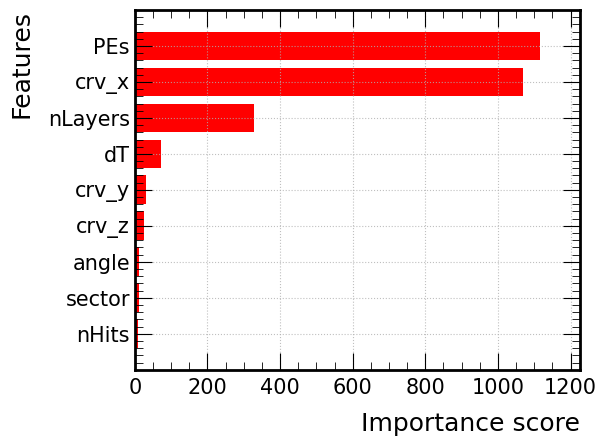

In [48]:
print("\n⭐️ Feature importance:") 
for feat, imp in zip(feature_names, model.feature_importances_):
    print(f"  {feat:10s}: {imp:.4f}") 

xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.8)
plt.title("")
plt.tight_layout()

img_validation_out_path = img_base_path / "validation"
img_validation_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_validation_out_path / "bar_feature_importance.png"
plt.savefig(out_name)

print(f"\tWrote {out_name}")
plt.show()

In [57]:
help(model.predict_proba)

Help on method predict_proba in module xgboost.sklearn:

predict_proba(X: Any, validate_features: bool = True, base_margin: Optional[Any] = None, iteration_range: Optional[Tuple[Union[int, numpy.integer], Union[int, numpy.integer]]] = None) -> numpy.ndarray method of xgboost.sklearn.XGBClassifier instance
    Predict the probability of each `X` example being of a given class. If the
    model is trained with early stopping, then :py:attr:`best_iteration` is used
    automatically. The estimator uses `inplace_predict` by default and falls back to
    using :py:class:`DMatrix` if devices between the data and the estimator don't
    match.

    .. note:: This function is only thread safe for `gbtree` and `dart`.

    Parameters
    ----------
    X :
        Feature matrix. See :ref:`py-data` for a list of supported types.
    validate_features :
        When this is True, validate that the Booster's and data's feature_names are
        identical.  Otherwise, it is assumed that the featur

In [56]:
model.predict_proba(X_train_scaled) # [:,1]

array([[9.9998873e-01, 1.1268792e-05],
       [9.9985933e-01, 1.4069179e-04],
       [9.9996203e-01, 3.7991536e-05],
       ...,
       [9.9997735e-01, 2.2669845e-05],
       [9.9996203e-01, 3.7991536e-05],
       [9.9992901e-01, 7.0965580e-05]], dtype=float32)

In [55]:
model.predict_proba(X_train_scaled)[:,1]

array([1.1268792e-05, 1.4069179e-04, 3.7991536e-05, ..., 2.2669845e-05,
       3.7991536e-05, 7.0965580e-05], dtype=float32)

In [49]:
train_pred = model.predict_proba(X_train_scaled)[:, 1]
test_pred = model.predict_proba(X_test_scaled)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
test_auc = roc_auc_score(y_test, test_pred)

print(f"\nTraining AUC: {train_auc:.6f}")
print(f"Test AUC: {test_auc:.6f}")


Training AUC: 0.999919
Test AUC: 0.999779


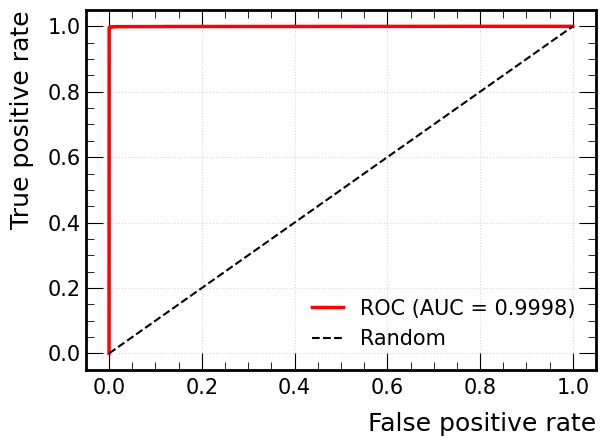


✅ Done! ROC curve saved to ../../output/images/ml/g/validation/roc_curve.png


In [50]:
fpr, tpr, _ = roc_curve(y_test, test_pred)

plt.figure()
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.tight_layout()

out_name = img_validation_out_path /  "roc_curve.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! ROC curve saved to {out_name}")

In [51]:
# Are there duplicate events?
print(f"Train events: {len(X_train)}")
print(f"Test events: {len(X_test)}")
print(f"Overlap: {len(set(X_train.index) & set(X_test.index))}")
print(feature_names)

Train events: 355475
Test events: 88869
Overlap: 0
['crv_x', 'crv_y', 'crv_z', 'PEs', 'dT', 'nHits', 'nLayers', 'angle', 'sector']


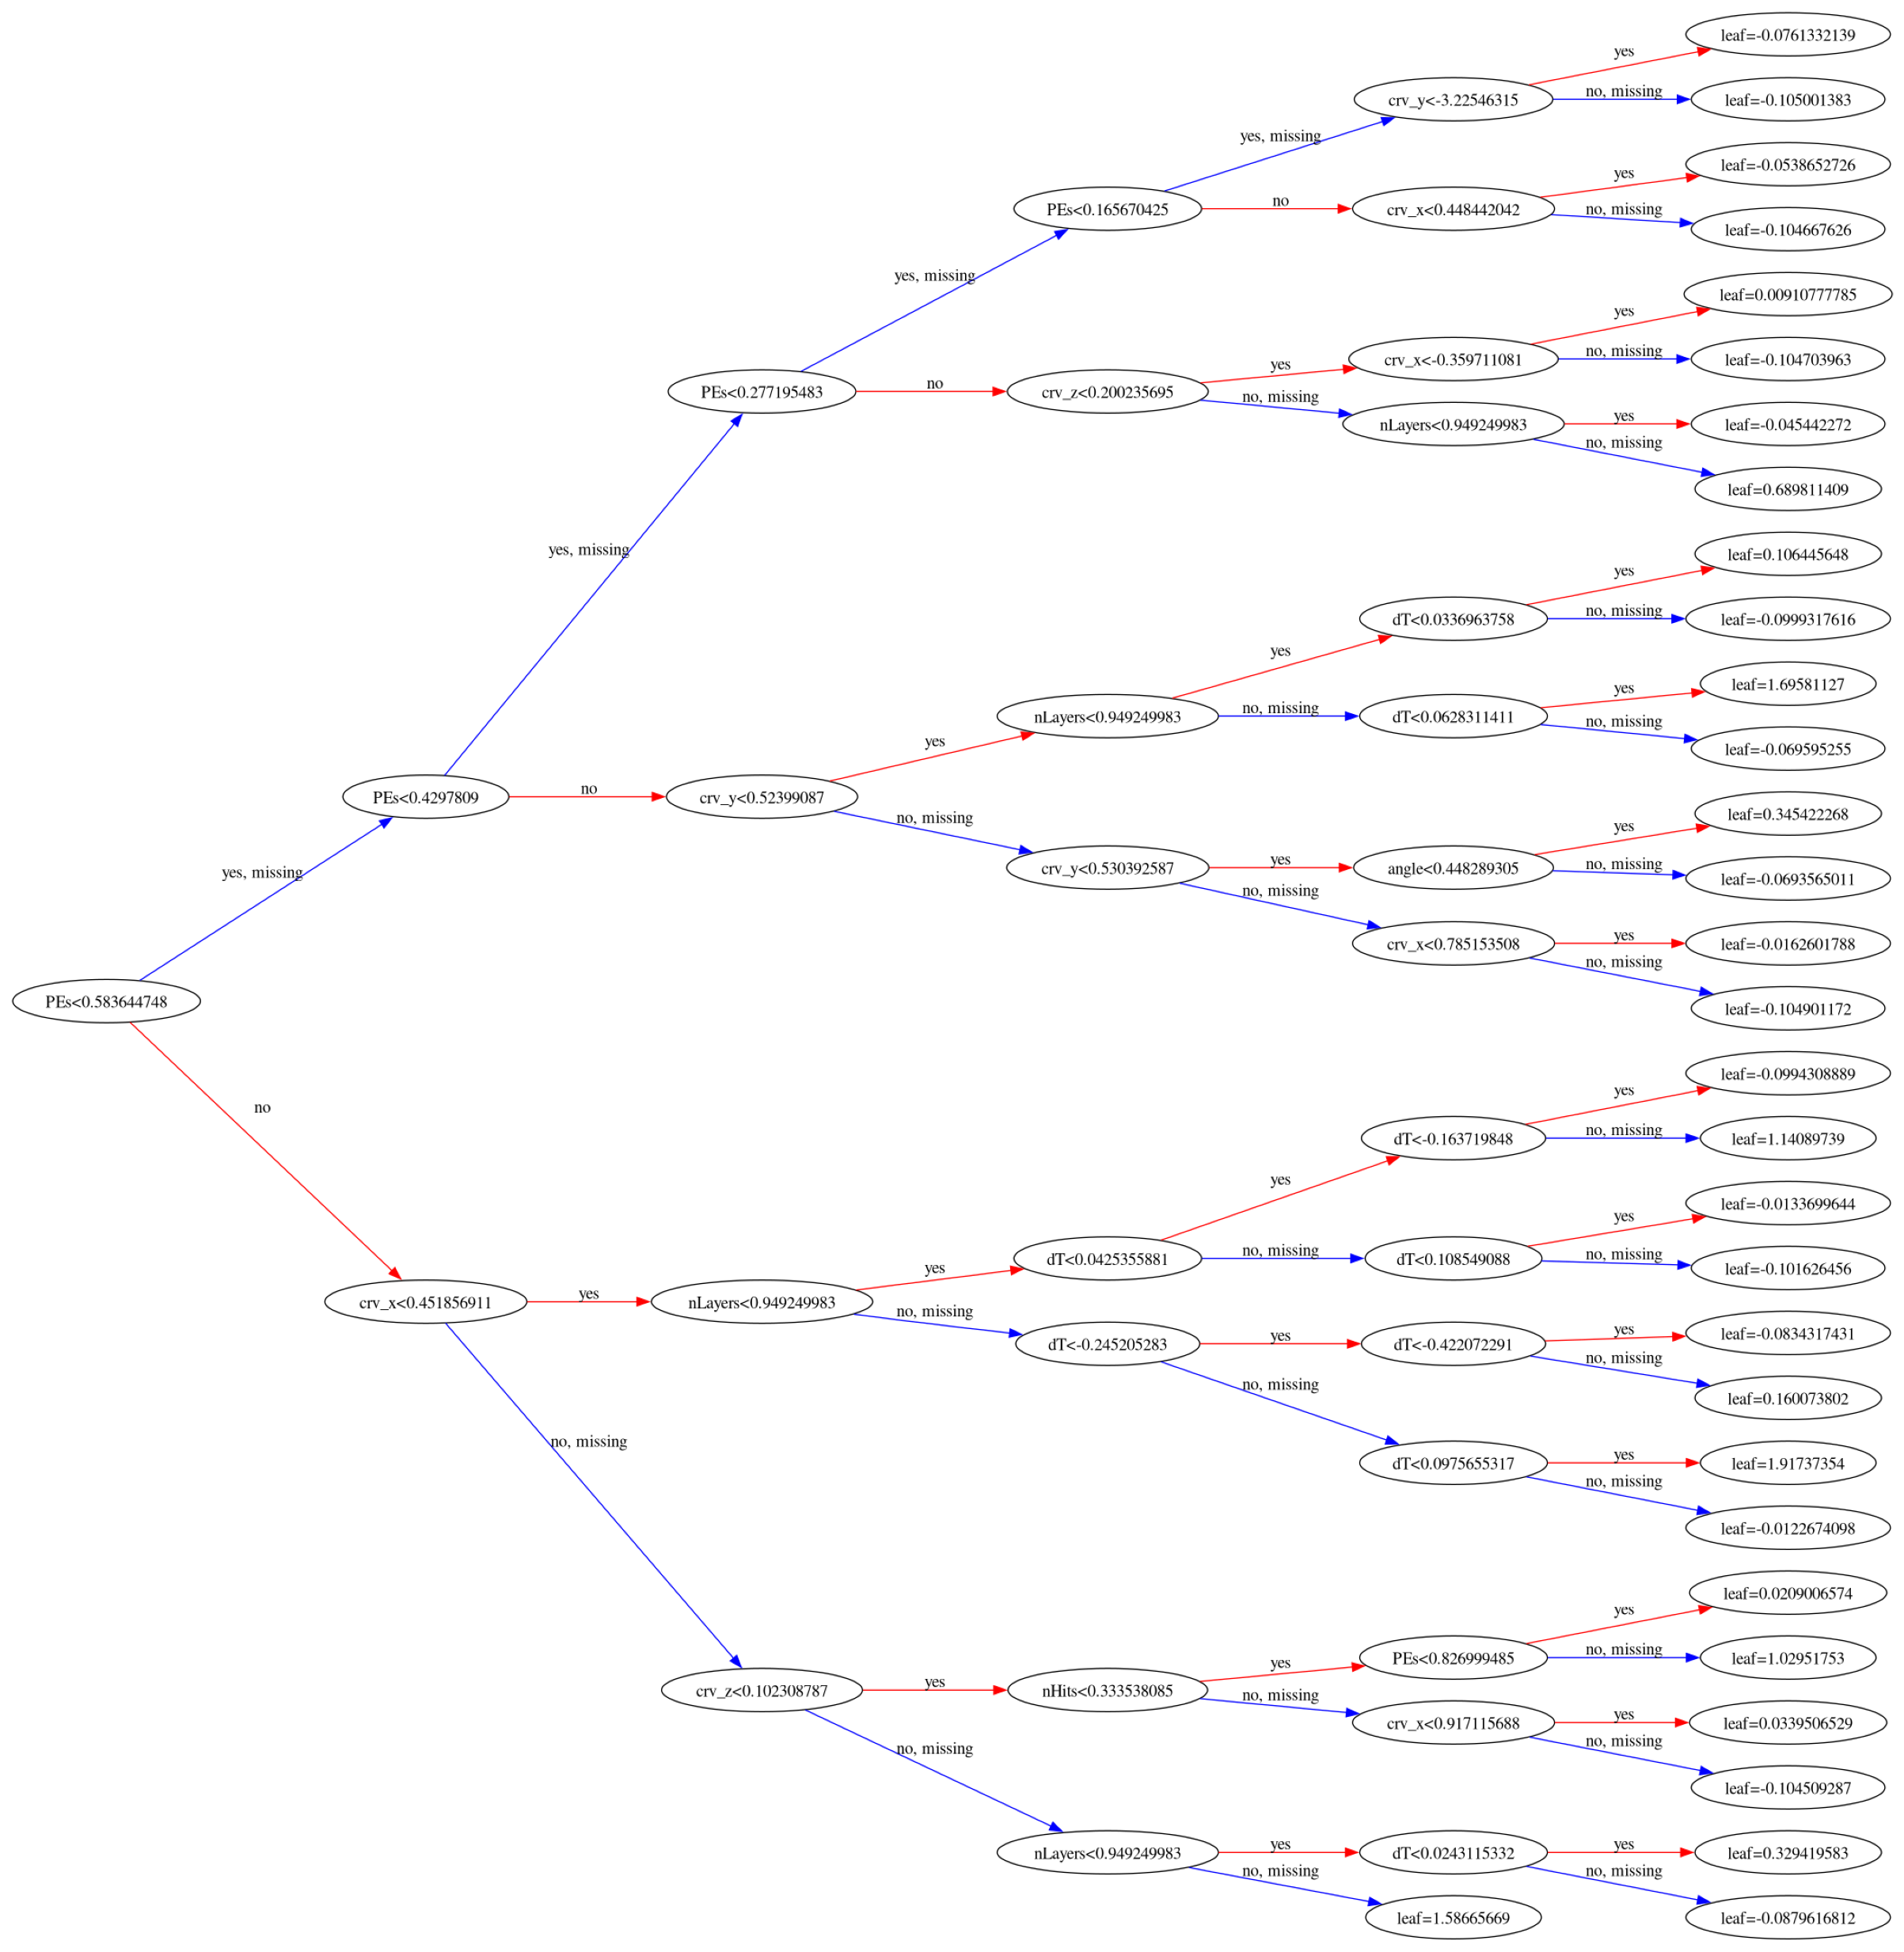


✅ Done! Tree saved to ../../output/images/ml/g/validation/tree_mix.png


In [69]:
fig, ax = plt.subplots(figsize=(25, 25))
xgb.plot_tree(model, num_trees=0, rankdir="LR", ax=ax)
plt.tight_layout()

out_name = img_validation_out_path / "tree_mix.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! Tree saved to {out_name}")

In [52]:
help(model.predict_proba)

Help on method predict_proba in module xgboost.sklearn:

predict_proba(X: Any, validate_features: bool = True, base_margin: Optional[Any] = None, iteration_range: Optional[Tuple[Union[int, numpy.integer], Union[int, numpy.integer]]] = None) -> numpy.ndarray method of xgboost.sklearn.XGBClassifier instance
    Predict the probability of each `X` example being of a given class. If the
    model is trained with early stopping, then :py:attr:`best_iteration` is used
    automatically. The estimator uses `inplace_predict` by default and falls back to
    using :py:class:`DMatrix` if devices between the data and the estimator don't
    match.

    .. note:: This function is only thread safe for `gbtree` and `dart`.

    Parameters
    ----------
    X :
        Feature matrix. See :ref:`py-data` for a list of supported types.
    validate_features :
        When this is True, validate that the Booster's and data's feature_names are
        identical.  Otherwise, it is assumed that the featur

	Wrote ../../output/images/ml/g/validation/h1o_model_output.png


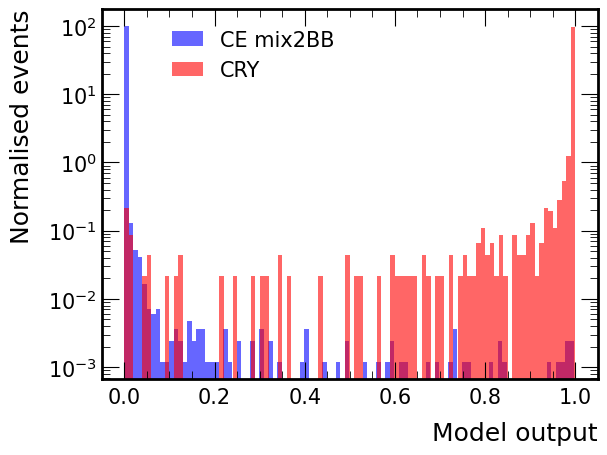

In [53]:
# Get test scores 
# Probability of the positive class (CRY)
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # CRY
background_scores = test_scores[y_test == 0]  # CE + mix2BB
    def accuracy(self):
        from sklearn.metrics import accuracy_score
        wsdcc
        return accuracy_score(self.y_true, self.y_pred)

    def precision(self):
        from sklearn.metrics import precision_score
        return precision_score(self.y_true, self.y_pred)
y_test
y_test
y_test
y_test
    def recall(self):
        from sklearn.metrics import recall_score
        return recall_score(self.y_true, self.y_pred)

    def f1_score(self):
        from sklearn.metrics import f1_score
        return f1_score(self.y_true, self.y_pred)

# Plot score distributions
plt.figure() 

plt.hist(background_scores, bins=100, alpha=0.6, label='CE mix2BB',
         density=True, color='blue')
plt.hist(signal_scores, bins=100, alpha=0.6, label='CRY',
         density=True, color='red')

plt.xlabel('Model output')
plt.ylabel('Normalised events')
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
plt.yscale('log')

out_name = img_validation_out_path / "h1o_model_output.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()




## Find threshold at 99.9% efficiency 


Threshold optimisation results




,Strategy,Threshold,Veto efficiency,Deadtime,Figure of merit
0,Signal significance,0.490,99.35%,0.03%,0.9932
1,Efficiency >= 99.9%,0.001,99.89%,1.52%,0.9837
2,Balanced FOM,0.041,99.70%,0.12%,0.9958



✅ Threshold optimisation plot saved to ../../output/images/ml/g/validation/threshold_optimisation.png


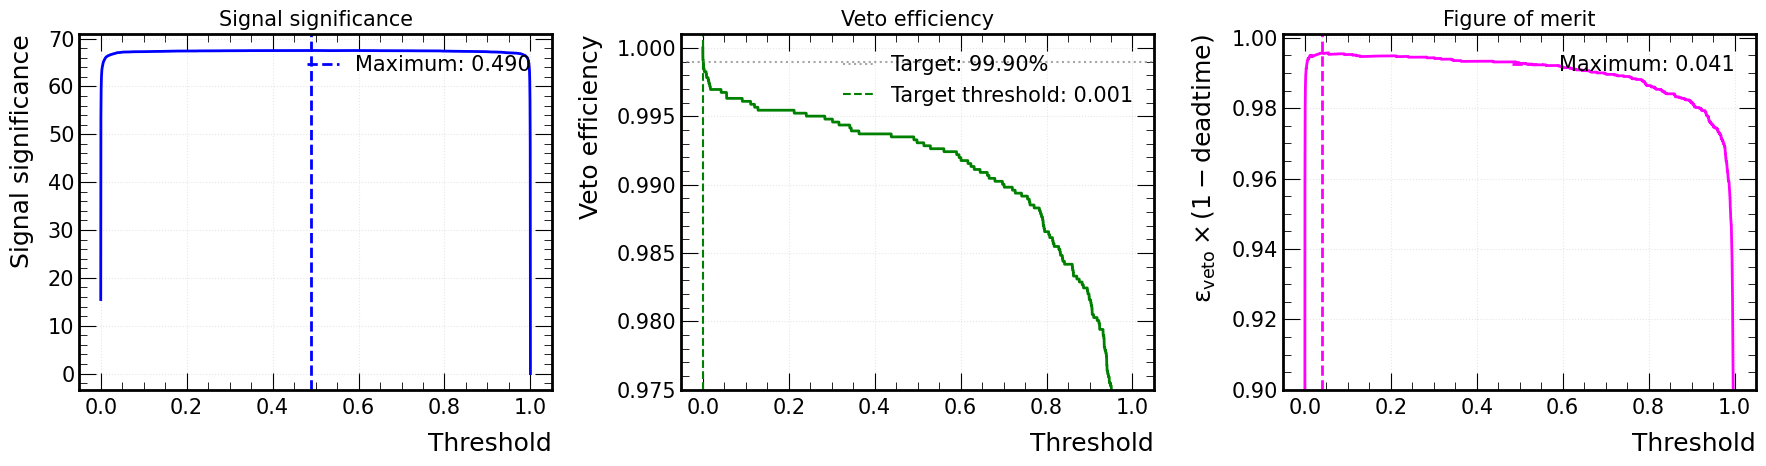

In [ ]:
thresholds = np.linspace(0, 1, 10000)

# Calculate all metrics in a single loop
veto_efficiencies = []
deadtime_losses = []
significance_values = []
 
for thr in thresholds:


    y_pred_label = (test_pred > thr).astype(int)
    
    # Calculate confusion matrix elements
    tp = ((y_test == 1) & (y_pred_label == 1)).sum()
    fn = ((y_test == 1) & (y_pred_label == 0)).sum()
    fp = ((y_test == 0) & (y_pred_label == 1)).sum()
    tn = ((y_test == 0) & (y_pred_label == 0)).sum()
    

    # Group by events/subrun 


    # Veto efficiency and deadtime
    veto_eff = tp / (tp + fn) if (tp + fn) > 0 else 0
    deadtime = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    veto_efficiencies.append(veto_eff)
    deadtime_losses.append(deadtime)
    
    # Signal significance (S/root(S+B))
    significance = tp / np.sqrt(tp + fp) if (tp + fp) > 0 else 0 the probability of each `X` example being of a given class. If the
    model is trained with early stopping, then :py:attr:`best_iteration` is used
    automatically. The estimator uses `inplace_predict` by default and falls back to
    using :py:class:`DMatrix` if devices between the data and the estimator don't
    match.
    significance_values.append(significance)

# Convert to numpy arrays for easier manipulation
veto_efficiencies = np.array(veto_efficiencies)
deadtime_losses = np.array(deadtime_losses)
significance_values = np.array(significance_values)

# Strategy 1: Signal significance (S/root(S+B))
optimal_idx_significance = np.argmax(significance_values)
optimal_threshold_significance = thresholds[optimal_idx_significance]
# Metrics 
eff_significance = veto_efficiencies[optimal_idx_significance]
dt_significance = deadtime_losses[optimal_idx_significance]
max_significance = significance_values[optimal_idx_significance]

# Strategy 2: Target 99.9% efficiency 
target_efficiency = 0.999
optimal_idx_eff = np.argmin(np.abs(veto_efficiencies - target_efficiency))
optimal_threshold_eff = thresholds[optimal_idx_eff]
# Metrics
eff_eff = veto_efficiencies[optimal_idx_eff]
dt_eff = deadtime_losses[optimal_idx_eff]

# Strategy 3: Balanced figure of merit (efficiency times (1 - deadtime))
figure_of_merit = veto_efficiencies * (1 - deadtime_losses)
optimal_idx_fom = np.argmax(figure_of_merit)
optimal_threshold_fom = thresholds[optimal_idx_fom]
# Metrics 
eff_fom = veto_efficiencies[optimal_idx_fom]
dt_fom = deadtime_losses[optimal_idx_fom]
fom_fom = figure_of_merit[optimal_idx_fom]

# Create comparison DataFrame
print("\n" + "="*80)
print("Threshold optimisation results")
print("="*80)

threshold_comparison_df = pd.DataFrame({
    'Strategy': [
        'Signal significance',
        'Efficiency >= 99.9%', 
        'Balanced FOM',
    ],
    'Threshold': [
        f"{optimal_threshold_significance:.3f}",
        f"{optimal_threshold_eff:.3f}",
        f"{optimal_threshold_fom:.3f}"
    ],
    'Veto efficiency': [
        f"{eff_significance*100:.2f}%",
        f"{eff_eff*100:.2f}%",
        f"{eff_fom*100:.2f}%"
    ],
    'Deadtime': [
        f"{dt_significance*100:.2f}%",
        f"{dt_eff*100:.2f}%",
        f"{dt_fom*100:.2f}%"
    ],
    'Figure of merit': [
        f"{eff_significance * (1 - dt_significance):.4f}",
        f"{eff_eff * (1 - dt_eff):.4f}",
        f"{fom_fom:.4f}"
    ]
})

print("\n")
display(threshold_comparison_df)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: Signal significance
axes[0].plot(thresholds, significance_values, linewidth=2, color='blue')
axes[0].axvline(optimal_threshold_significance, color='blue', linestyle='--', linewidth=2,
                label=f'Maximum: {optimal_threshold_significance:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Signal significance')
axes[0].set_title('Signal significance')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Middle: Veto efficiency vs threshold
axes[1].plot(thresholds, veto_efficiencies, linewidth=2, color='green')
axes[1].axhline(target_efficiency, color='grey', linestyle=':', linewidth=1.5, alpha=0.7,
                label=f'Target: {target_efficiency*100:.2f}%')
axes[1].axvline(optimal_threshold_eff, color='green', linestyle='--', linewidth=1.5, 
                label=f'Target threshold: {optimal_threshold_eff:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Veto efficiency')
axes[1].set_title('Veto efficiency')
axes[1].set_ylim([0.975, 1.001])
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

# Right: Balanced figure of merit
axes[2].plot(thresholds, figure_of_merit, linewidth=2, color='magenta')
axes[2].axvline(optimal_threshold_fom, color='magenta', linestyle='--', linewidth=2,
                label=f'Maximum: {optimal_threshold_fom:.3f}')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel(r'$\epsilon_{\text{veto}}\times(1-\text{deadtime})$')
axes[2].set_title('Figure of merit')
axes[2].set_ylim([0.9, 1.001])
axes[2].legend(loc='upper right')
axes[2].grid(alpha=0.3)

plt.tight_layout()

out_name = img_validation_out_path / "threshold_optimisation.png"
plt.savefig(out_name)
print(f"\n✅ Threshold optimisation plot saved to {out_name}")

plt.show()


✅ Metrics overlay plot saved to ../../output/images/ml/g/validation/threshold_metrics_overlay.png


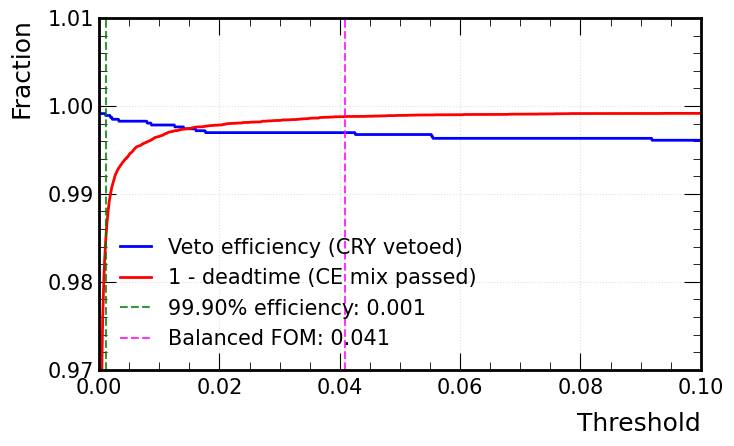

In [74]:
# Create overlay plot
fig, ax = plt.subplots(figsize=(1.2*6.4, 4.8))

ax.plot(thresholds, veto_efficiencies, linewidth=2, color='blue', label='Veto efficiency (CRY vetoed)')
ax.plot(thresholds, 1 - deadtime_losses, linewidth=2, color='red', label='1 - deadtime (CE mix passed)')

# Add vertical lines for your three strategies
ax.axvline(optimal_threshold_eff, color='green', linestyle='--', alpha=0.8, linewidth=1.5,
           label=f'{100*target_efficiency:.2f}% efficiency: {optimal_threshold_eff:.3f}')
ax.axvline(optimal_threshold_fom, color='magenta', linestyle='--', alpha=0.8, linewidth=1.5, label=f'Balanced FOM: {optimal_threshold_fom:.3f}')
# ax.axvline(optimal_threshold_significance, color='orange', linestyle=':', alpha=0.8, 
#            label=f'Signal significance: {optimal_threshold_significance:.3f}')

ax.set_xlabel('Threshold')
ax.set_ylabel('Fraction')
# ax.set_title('Performance vs threshold')
ax.set_ylim([0.97, 1.01])
ax.set_xlim([0, 0.1])
ax.legend(loc='best') # , frameon=True)
ax.grid(alpha=0.4)

plt.tight_layout()

out_name = img_validation_out_path / "threshold_metrics_overlay.png"
plt.savefig(out_name)
print(f"\n✅ Metrics overlay plot saved to {out_name}")

plt.show()

In [76]:
optimal_threshold = optimal_threshold_eff 

	Wrote ../../output/images/ml/g/validation/h1o_1x2_model_output.png


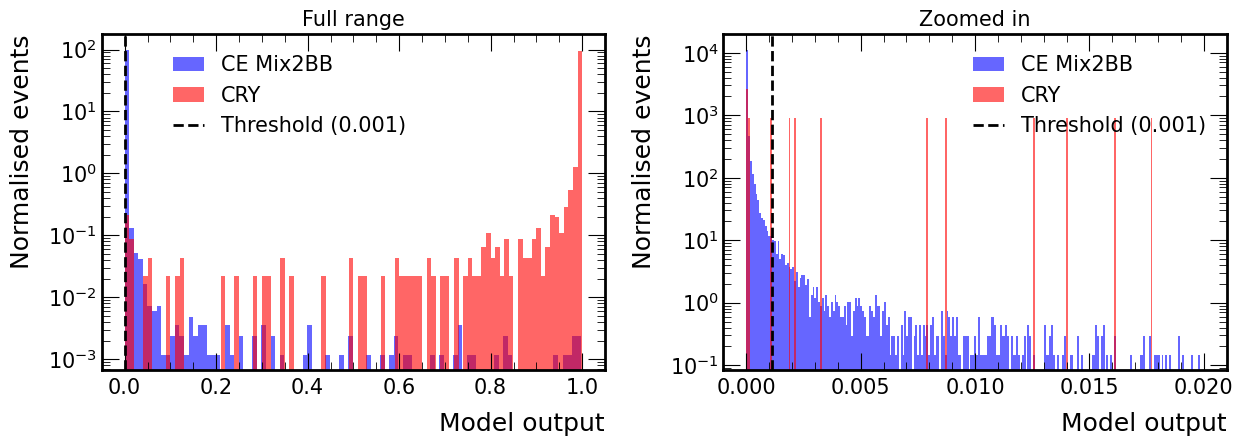

In [81]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # CRY
background_scores = test_scores[y_test == 0]  # CE + mix2BB

# Define threshold
threshold = optimal_threshold

# Plot score distributions
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

nbins = 250
# Left: Full range
ax[0].hist(background_scores, bins=100, alpha=0.6, label='CE Mix2BB',
           density=True, color='blue')
ax[0].hist(signal_scores, bins=100, alpha=0.6, label='CRY',
           density=True, color='red')
ax[0].axvline(optimal_threshold, color='black', linestyle='--', linewidth=2.0, label=f"Threshold ({optimal_threshold:.3f})")
ax[0].set_xlabel('Model output')
ax[0].set_ylabel('Normalised events')
ax[0].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[0].set_yscale('log')
ax[0].set_title('Full range')

# Right: Zoomed in on x-axis around threshold
bins_zoom = np.linspace(0, 0.02, nbins)
ax[1].hist(background_scores, bins=bins_zoom, alpha=0.6, label='CE Mix2BB',
           density=True, color='blue')
ax[1].hist(signal_scores, bins=bins_zoom, alpha=0.6, label='CRY',
           density=True, color='red')
ax[1].axvline(optimal_threshold, color='black', linestyle='--', linewidth=2.0, label=f"Threshold ({optimal_threshold:.3f})")
ax[1].set_xlabel('Model output')
ax[1].set_ylabel('Normalised events')
ax[1].legend(loc="best")
ax[1].set_yscale('log')
# ax[1].set_xlim([0, 0.05])  # Zoomed in range
ax[1].set_title('Zoomed in')

plt.tight_layout()

out_name = img_validation_out_path / "h1o_1x2_model_output.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()


## Simple dT baseline veto efficiency and deadtime for CRY

In [92]:
# ==========================================
# SIMPLE dT CUT - PURE CRY ONLY
# ==========================================

# Filter to only CRY events (label == 1)
cry_mask = y_test == 1
X_test_cry = X_test[cry_mask]
y_test_cry = y_test[cry_mask]
metadata_test_cry = metadata_test[cry_mask]

print(f"Total CRY test entries: {len(X_test_cry)}")

# Apply dT cut: veto if dT is in range [-25, 150] ns
dT_cry = X_test_cry['dT'].values
y_pred_dt_cut = ((dT_cry >= -25) & (dT_cry <= 150)).astype(int)

# Group by event/subrun to get event-level veto decision
test_df_cry = X_test_cry.copy()
test_df_cry['event'] = metadata_test_cry['event'].values
test_df_cry['subrun'] = metadata_test_cry['subrun'].values
test_df_cry['y_true'] = y_test_cry.values
test_df_cry['y_pred_dt_cut'] = y_pred_dt_cut

event_grouped = test_df_cry.groupby(['subrun', 'event'])
event_level = event_grouped.agg({
    'y_true': 'first',  # All are CRY (label=1)
    'y_pred_dt_cut': 'max'  # Event is vetoed if ANY combination passes dT cut
}).reset_index()

y_test_cry_event = event_level['y_true'].values
y_pred_dt_cut_event = event_level['y_pred_dt_cut'].values

print(f"Unique CRY events in test set: {len(event_level)}")
print(f"Events with at least one coincidence passing dT cut: {y_pred_dt_cut_event.sum()}")
    
# Calculate event-based veto efficiency for dT cut
# For pure CRY, we only care about veto efficiency (how many we catch)
n_events_vetoed = y_pred_dt_cut_event.sum()
n_events_total = len(y_pred_dt_cut_event)

veto_efficiency_dt = n_events_vetoed / n_events_total
veto_inefficiency_dt = 1 - veto_efficiency_dt

print("\n" + "="*80)
print("BASELINE dT CUT PERFORMANCE (PURE CRY ONLY)")
print("="*80)
print(f"dT window: [-25, 150] ns")
print(f"\nTotal CRY events: {n_events_total}")
print(f"Events vetoed: {n_events_vetoed}")
print(f"Veto efficiency: {veto_efficiency_dt*100:.3f}%")
print(f"Veto inefficiency: {veto_inefficiency_dt*100:.3f}%")

Total CRY test entries: 4615
Unique CRY events in test set: 4472
Events with at least one coincidence passing dT cut: 4465

BASELINE dT CUT PERFORMANCE (PURE CRY ONLY)
dT window: [-25, 150] ns

Total CRY events: 4472
Events vetoed: 4465
Veto efficiency: 99.843%
Veto inefficiency: 0.157%


## Confusion matrix

In [ ]:
get_cmatrix(y_test, y_pred): 


y_pred_dt_cut_event, title="dT Cut Confusion Matrix (CRY only)")  

In [83]:
# ==========================================
# CRV VETO PERFORMANCE METRICS
# ==========================================

# LABELS:
#   Label 1 (CRY): Pure cosmic sample - want to VETO
#   Label 0 (CE mix): Mixed CE sample (true CE + pileup cosmics) - want to PASS

# We also have NaN coincidences which must be included in the demoninators in both cases 
# Also, the "true" veto efficiency is event-based, so we need to group by event/subrun 
# and find out if any of the combinations were vetoed 

# Get predictions at optimal threshold
y_pred_veto = (test_scores > optimal_threshold).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_veto)
tn, fp, fn, tp = cm.ravel()

# Core veto metrics
veto_efficiency = tp / (tp + fn)  # Fraction of pure cosmics caught
veto_inefficiency = fn / (tp + fn)  # Fraction of pure cosmics that leak through
deadtime_loss = fp / (tn + fp)  # Fraction of CE mix incorrectly vetoed
veto_purity = tp / (tp + fp) if (tp + fp) > 0 else 0  # Of vetoed events, fraction that are pure cosmics

In [84]:
# ==========================================
# EVENT-BASED VETO METRICS WITH NaN HANDLING
# ==========================================

# Reconstruct test DataFrame with predictions
df_test = pd.DataFrame({
    'event': metadata_test['event'].values,
    'subrun': metadata_test['subrun'].values,
    'label': y_test.values,
    'score': test_scores,
    'veto': y_pred_veto
})

# Add back the features to check for NaN
df_test_full = pd.concat([
    metadata_test.reset_index(drop=True),
    X_test.reset_index(drop=True),
    pd.DataFrame({'label': y_test.values, 'score': test_scores, 'veto': y_pred_veto})
], axis=1)

# Check for NaN in features (events with no CRV coincidence)
df_test_full['has_nan'] = df_test_full[feature_names].isna().any(axis=1)

print(f"Total test entries: {len(df_test_full)}")
print(f"Entries with NaN: {df_test_full['has_nan'].sum()}")
print(f"Entries without NaN: {(~df_test_full['has_nan']).sum()}")

# Group by event to get event-level decisions
# An event is VETOED if ANY of its coincidences (including NaN) are vetoed
# For NaN rows, the model can't score them, so we need to decide how to handle them

# Strategy: Events with NaN are considered "no coincidence" -> can't veto
# So we need to check if the event has at least one non-NaN coincidence that was vetoed

event_groups = df_test_full.groupby(['subrun', 'event']).agg({
    'label': 'first',  # All rows in a group have same label
    'veto': 'max',     # Event is vetoed if ANY coincidence is vetoed
    'has_nan': 'any',  # Does this event have any NaN coincidences?
    'score': 'max'     # Maximum score across all coincidences
}).reset_index()

print(f"\nUnique events in test set: {len(event_groups)}")
print(f"Events with at least one NaN coincidence: {event_groups['has_nan'].sum()}")

# Separate by true label
cry_events = event_groups[event_groups['label'] == 1]  # Pure cosmics - should be vetoed
ce_mix_events = event_groups[event_groups['label'] == 0]  # CE mix - should pass

# Calculate event-based metrics
n_cry_vetoed = cry_events['veto'].sum()
n_cry_total = len(cry_events)
n_ce_mix_vetoed = ce_mix_events['veto'].sum()
n_ce_mix_total = len(ce_mix_events)

event_veto_efficiency = n_cry_vetoed / n_cry_total
event_veto_inefficiency = 1 - event_veto_efficiency
event_deadtime_loss = n_ce_mix_vetoed / n_ce_mix_total

print("\n" + "="*80)
print("EVENT-BASED METRICS")
print("="*80)
print(f"\nCRY (pure cosmics - should veto):")
print(f"  Total events: {n_cry_total}")
print(f"  Vetoed: {n_cry_vetoed}")
print(f"  Veto efficiency: {event_veto_efficiency*100:.3f}%")
print(f"  Veto inefficiency: {event_veto_inefficiency*100:.3f}%")

print(f"\nCE Mix2BB (signal + pileup - should pass):")
print(f"  Total events: {n_ce_mix_total}")
print(f"  Incorrectly vetoed: {n_ce_mix_vetoed}")
print(f"  Deadtime loss: {event_deadtime_loss*100:.3f}%")
print(f"  Pass rate: {(1-event_deadtime_loss)*100:.3f}%")

print("\n" + "="*80)
print("COINCIDENCE-LEVEL METRICS (for comparison)")
print("="*80)
print(f"\nVeto efficiency (coincidence): {veto_efficiency*100:.3f}%")
print(f"Veto inefficiency (coincidence): {(1-veto_efficiency)*100:.3f}%")
print(f"Deadtime loss (coincidence): {deadtime_loss*100:.3f}%")
print(f"Veto purity (coincidence): {veto_purity*100:.3f}%")

# Create summary DataFrame
metrics_summary = pd.DataFrame({
    'Metric': [
        'Veto efficiency',
        'Veto inefficiency', 
        'Deadtime loss',
        'Pass rate (1 - deadtime)'
    ],
    'Event-based': [
        f"{event_veto_efficiency*100:.3f}%",
        f"{event_veto_inefficiency*100:.3f}%",
        f"{event_deadtime_loss*100:.3f}%",
        f"{(1-event_deadtime_loss)*100:.3f}%"
    ],
    'Coincidence-based': [
        f"{veto_efficiency*100:.3f}%",
        f"{(1-veto_efficiency)*100:.3f}%",
        f"{deadtime_loss*100:.3f}%",
        f"{(1-deadtime_loss)*100:.3f}%"
    ]
})

print("\n" + "="*80)
print("COMPARISON")
print("="*80)
display(metrics_summary)

Total test entries: 88869
Entries with NaN: 30088
Entries without NaN: 58781

Unique events in test set: 81268
Events with at least one NaN coincidence: 30088

EVENT-BASED METRICS

CRY (pure cosmics - should veto):
  Total events: 4472
  Vetoed: 4467
  Veto efficiency: 99.888%
  Veto inefficiency: 0.112%

CE Mix2BB (signal + pileup - should pass):
  Total events: 76796
  Incorrectly vetoed: 1273
  Deadtime loss: 1.658%
  Pass rate: 98.342%

COINCIDENCE-LEVEL METRICS (for comparison)

Veto efficiency (coincidence): 99.892%
Veto inefficiency (coincidence): 0.108%
Deadtime loss (coincidence): 1.520%
Veto purity (coincidence): 78.255%

COMPARISON


,Metric,Event-based,Coincidence-based
0,Veto efficiency,99.888%,99.892%
1,Veto inefficiency,0.112%,0.108%
2,Deadtime loss,1.658%,1.520%
3,Pass rate (1 - deadtime),98.342%,98.480%


## Comparison with simple dT cut


SIMPLE dT CUT OPTIMIZATION




,Strategy,dT threshold [ns],Veto efficiency,Deadtime,Figure of merit
0,Efficiency >= 99.9%,131.98,99.85%,14.26%,0.8561
1,Balanced FOM,102.55,99.41%,11.16%,0.0992



✅ dT cut optimization plot saved to ../../output/images/ml/g/validation/dT_cut_optimization.png


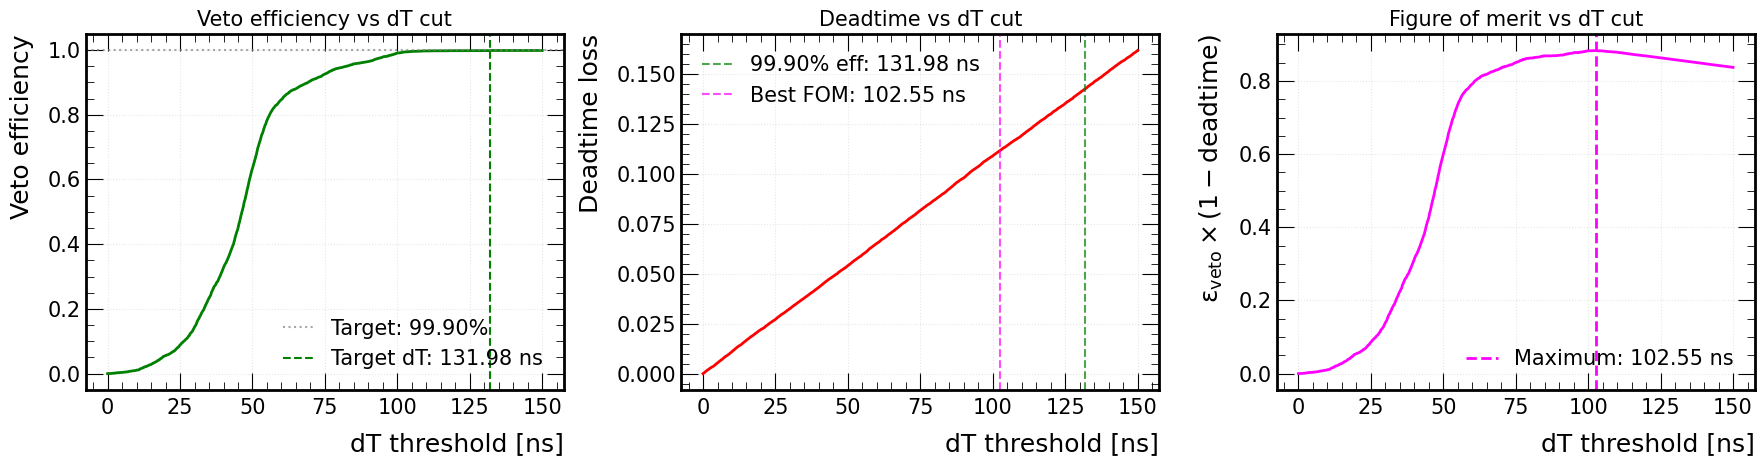

In [85]:
# ==========================================
# SIMPLE dT CUT BASELINE FOR COMPARISON
# ==========================================

# Traditional approach: veto if |dT| < some threshold
# Need to scan dT thresholds to find optimal value

# Get dT values from test set
dT_test = X_test['dT'].values

# Scan dT thresholds
dT_thresholds = np.linspace(0, 150, 1000)  # Adjust range based on your dT distribution

dT_veto_efficiencies = []
dT_deadtime_losses = []
dT_figure_of_merit = []

for dT_thr in dT_thresholds:
    # Veto if |dT| < threshold (small dT means good temporal coincidence -> cosmic)
    y_pred_dT = (np.abs(dT_test) < dT_thr).astype(int)
    
    # Calculate metrics (coincidence-level)
    tp = ((y_test == 1) & (y_pred_dT == 1)).sum()
    fn = ((y_test == 1) & (y_pred_dT == 0)).sum()
    fp = ((y_test == 0) & (y_pred_dT == 1)).sum()
    tn = ((y_test == 0) & (y_pred_dT == 0)).sum()
    
    veto_eff = tp / (tp + fn) if (tp + fn) > 0 else 0
    deadtime = fp / (fp + tn) if (fp + tn) > 0 else 0
    fom = veto_eff * (1 - deadtime)
    
    dT_veto_efficiencies.append(veto_eff)
    dT_deadtime_losses.append(deadtime)
    dT_figure_of_merit.append(fom)

dT_veto_efficiencies = np.array(dT_veto_efficiencies)
dT_deadtime_losses = np.array(dT_deadtime_losses)
dT_figure_of_merit = np.array(dT_figure_of_merit)

# Find optimal dT cut using same strategies
# Strategy 1: Target 99.9% efficiency
optimal_dT_idx_eff = np.argmin(np.abs(dT_veto_efficiencies - target_efficiency))
optimal_dT_eff = dT_thresholds[optimal_dT_idx_eff]
dT_eff_eff = dT_veto_efficiencies[optimal_dT_idx_eff]
dT_dt_eff = dT_deadtime_losses[optimal_dT_idx_eff]

# Strategy 2: Balanced FOM
optimal_dT_idx_fom = np.argmax(dT_figure_of_merit)
optimal_dT_fom = dT_thresholds[optimal_dT_idx_fom]
dT_eff_fom = dT_veto_efficiencies[optimal_dT_idx_fom]
dT_dt_fom = dT_deadtime_losses[optimal_dT_idx_fom]

print("\n" + "="*80)
print("SIMPLE dT CUT OPTIMIZATION")
print("="*80)

dT_comparison_df = pd.DataFrame({
    'Strategy': [
        'Efficiency >= 99.9%',
        'Balanced FOM'
    ],
    'dT threshold [ns]': [
        f"{optimal_dT_eff:.2f}",
        f"{optimal_dT_fom:.2f}"
    ],
    'Veto efficiency': [
        f"{dT_eff_eff*100:.2f}%",
        f"{dT_eff_fom*100:.2f}%"
    ],
    'Deadtime': [
        f"{dT_dt_eff*100:.2f}%",
        f"{dT_dt_fom*100:.2f}%"
    ],
    'Figure of merit': [
        f"{dT_eff_eff * (1 - dT_dt_eff):.4f}",
        f"{dT_dt_fom * (1 - dT_dt_fom):.4f}"
    ]
})

print("\n")
display(dT_comparison_df)

# Plot dT cut performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: Veto efficiency vs dT threshold
axes[0].plot(dT_thresholds, dT_veto_efficiencies, linewidth=2, color='green')
axes[0].axhline(target_efficiency, color='grey', linestyle=':', linewidth=1.5, alpha=0.7,
                label=f'Target: {target_efficiency*100:.2f}%')
axes[0].axvline(optimal_dT_eff, color='green', linestyle='--', linewidth=1.5,
                label=f'Target dT: {optimal_dT_eff:.2f} ns')
axes[0].set_xlabel('dT threshold [ns]')
axes[0].set_ylabel('Veto efficiency')
axes[0].set_title('Veto efficiency vs dT cut')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# Middle: Deadtime vs dT threshold
axes[1].plot(dT_thresholds, dT_deadtime_losses, linewidth=2, color='red')
axes[1].axvline(optimal_dT_eff, color='green', linestyle='--', linewidth=1.5, alpha=0.7,
                label=f'{target_efficiency*100:.2f}% eff: {optimal_dT_eff:.2f} ns')
axes[1].axvline(optimal_dT_fom, color='magenta', linestyle='--', linewidth=1.5, alpha=0.7,
                label=f'Best FOM: {optimal_dT_fom:.2f} ns')
axes[1].set_xlabel('dT threshold [ns]')
axes[1].set_ylabel('Deadtime loss')
axes[1].set_title('Deadtime vs dT cut')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

# Right: Figure of merit
axes[2].plot(dT_thresholds, dT_figure_of_merit, linewidth=2, color='magenta')
axes[2].axvline(optimal_dT_fom, color='magenta', linestyle='--', linewidth=2,
                label=f'Maximum: {optimal_dT_fom:.2f} ns')
axes[2].set_xlabel('dT threshold [ns]')
axes[2].set_ylabel(r'$\epsilon_{\text{veto}}\times(1-\text{deadtime})$')
axes[2].set_title('Figure of merit vs dT cut')
axes[2].legend(loc='best')
axes[2].grid(alpha=0.3)

plt.tight_layout()

out_name = img_validation_out_path / "dT_cut_optimization.png"
plt.savefig(out_name)
print(f"\n✅ dT cut optimization plot saved to {out_name}")

plt.show()

In [ ]:
# ==========================================
# EVENT-BASED METRICS FOR dT CUT
# ==========================================

# Use optimal dT cut (targeting 99.9% efficiency to match XGBoost)
optimal_dT_cut = optimal_dT_eff

# Apply dT cut to full test set
df_test_full['veto_dT'] = (np.abs(df_test_full['dT']) < optimal_dT_cut).astype(int)

# Group by event - veto if ANY coincidence passes dT cut
event_groups_dT = df_test_full.groupby(['subrun', 'event']).agg({
    'label': 'first',
    'veto_dT': 'max',  # Event vetoed if ANY coincidence has |dT| < threshold
    'has_nan': 'any'
}).reset_index()

# Separate by label
cry_events_dT = event_groups_dT[event_groups_dT['label'] == 1]
ce_mix_events_dT = event_groups_dT[event_groups_dT['label'] == 0]

# Calculate event-based metrics for dT cut
n_cry_vetoed_dT = cry_events_dT['veto_dT'].sum()
n_cry_total_dT = len(cry_events_dT)
n_ce_mix_vetoed_dT = ce_mix_events_dT['veto_dT'].sum()
n_ce_mix_total_dT = len(ce_mix_events_dT)

event_veto_efficiency_dT = n_cry_vetoed_dT / n_cry_total_dT
event_veto_inefficiency_dT = 1 - event_veto_efficiency_dT
event_deadtime_loss_dT = n_ce_mix_vetoed_dT / n_ce_mix_total_dT

print("\n" + "="*80)
print(f"EVENT-BASED METRICS FOR dT CUT (|dT| < {optimal_dT_cut:.2f} ns)")
print("="*80)
print(f"\nCRY (pure cosmics - should veto):")
print(f"  Total events: {n_cry_total_dT}")
print(f"  Vetoed: {n_cry_vetoed_dT}")
print(f"  Veto efficiency: {event_veto_efficiency_dT*100:.3f}%")
print(f"  Veto inefficiency: {event_veto_inefficiency_dT*100:.3f}%")

print(f"\nCE Mix2BB (signal + pileup - should pass):")
print(f"  Total events: {n_ce_mix_total_dT}")
print(f"  Incorrectly vetoed: {n_ce_mix_vetoed_dT}")
print(f"  Deadtime loss: {event_deadtime_loss_dT*100:.3f}%")
print(f"  Pass rate: {(1-event_deadtime_loss_dT)*100:.3f}%")

In [ ]:
# ==========================================
# XGBOOST vs dT CUT COMPARISON
# ==========================================

print("\n" + "="*80)
print("PERFORMANCE COMPARISON: XGBoost vs Simple dT Cut")
print("="*80)

comparison_df = pd.DataFrame({
    'Method': ['XGBoost ML', 'Simple dT cut'],
    'Threshold': [
        f'{optimal_threshold:.4f} (model score)',
        f'{optimal_dT_cut:.2f} ns (|dT|)'
    ],
    'Veto Efficiency (Event)': [
        f'{event_veto_efficiency*100:.3f}%',
        f'{event_veto_efficiency_dT*100:.3f}%'
    ],
    'Deadtime Loss (Event)': [
        f'{event_deadtime_loss*100:.3f}%',
        f'{event_deadtime_loss_dT*100:.3f}%'
    ],
    'Figure of Merit': [
        f'{event_veto_efficiency * (1 - event_deadtime_loss):.5f}',
        f'{event_veto_efficiency_dT * (1 - event_deadtime_loss_dT):.5f}'
    ]
})

print("\n")
display(comparison_df)

# Calculate improvement
deadtime_improvement = ((event_deadtime_loss_dT - event_deadtime_loss) / event_deadtime_loss_dT) * 100
fom_improvement = ((event_veto_efficiency * (1 - event_deadtime_loss) - 
                    event_veto_efficiency_dT * (1 - event_deadtime_loss_dT)) / 
                   (event_veto_efficiency_dT * (1 - event_deadtime_loss_dT))) * 100

print("\n" + "="*80)
print("IMPROVEMENT")
print("="*80)
print(f"Deadtime reduction: {deadtime_improvement:.2f}%")
print(f"  dT cut: {event_deadtime_loss_dT*100:.3f}% → XGBoost: {event_deadtime_loss*100:.3f}%")
print(f"\nFigure of merit improvement: {fom_improvement:.2f}%")
print(f"  dT cut: {event_veto_efficiency_dT * (1 - event_deadtime_loss_dT):.5f} → XGBoost: {event_veto_efficiency * (1 - event_deadtime_loss):.5f}")

# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar chart of key metrics
methods = ['XGBoost', 'dT cut']
veto_effs = [event_veto_efficiency * 100, event_veto_efficiency_dT * 100]
deadtimes = [event_deadtime_loss * 100, event_deadtime_loss_dT * 100]

x = np.arange(len(methods))
width = 0.35

bars1 = axes[0].bar(x - width/2, veto_effs, width, label='Veto efficiency', color='green', alpha=0.8)
bars2 = axes[0].bar(x + width/2, deadtimes, width, label='Deadtime loss', color='red', alpha=0.8)

axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Event-based performance comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].legend(loc='upper right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 105])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

# Right: Figure of merit comparison
foms = [
    event_veto_efficiency * (1 - event_deadtime_loss),
    event_veto_efficiency_dT * (1 - event_deadtime_loss_dT)
]

bars = axes[1].bar(methods, foms, color=['blue', 'orange'], alpha=0.8)
axes[1].set_ylabel('Figure of merit')
axes[1].set_title(r'$\epsilon_{\text{veto}} \times (1 - \text{deadtime})$')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.97, 1.0])

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.5f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

out_name = img_validation_out_path / "xgboost_vs_dT_comparison.png"
plt.savefig(out_name)
print(f"\n✅ Comparison plot saved to {out_name}")

plt.show()